In [ ]:
# Load environment variables from .env at the repository root
from dotenv import load_dotenv
load_dotenv()


In [ ]:
import os
from datetime import datetime
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from src.pipelines.evaluation.rag_eval_pipeline import get_rag_evaluation_pipeline
from src.models import EmbeddingModelConfig, EmbeddingModelProvider, LLMConfig, LLMProvider, RerankingModelConfig, RerankingModelProvider, RewriterModelConfig
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.dataclasses import ChatMessage
from src.config.prompt import PROMPT_TEMPLATE

In [7]:
from config.secret import OPENAI_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

os.environ["SENTENCE_TRANSFORMERS_HOME"] = "./model-assets/sentence-transformers"

In [8]:
test_configs = [
    {
        "name": "Open Source RAG (Top-k=5)",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": RerankingModelConfig(name="Qwen/Qwen3-Reranker-8B", provider=RerankingModelProvider.HUGGING_FACE),
        "contextualizer_model": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, context_length=40000),
        "rewriter_model": RewriterModelConfig(
            LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, context_length=40000),
            """You are a helpful assistant that rewrites a user's question for a RAG system. 
            Keep the original meaning and language. Strip out filler words and irrelevant context, preserve all named entities and technical terms, and enrich phrasing with clearer structure or synonyms. 
            If prior messages are provided, include only the essential details from them to ensure the question is fully self-contained. 
            Output only the rewritten question—no additional text.

            Example 1
            Original: “Um, like, what medication should I take for my morning headaches? I've been getting them almost every day.”
            Rewritten: Which medication is most effective for treating daily morning headaches?

            Example 2
            Original: “Hey, I'm confused—what's the normal blood pressure range for adults? I've seen different numbers online.”
            Rewritten: What is the normal adult blood pressure range?
            """,
        ),
        "llm": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, context_length=40000),
        "retrieval-top-k": 5,
    },
    {
        "name": "Open Source RAG (Top-k=10)",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": RerankingModelConfig(name="Qwen/Qwen3-Reranker-8B", provider=RerankingModelProvider.HUGGING_FACE),
        "contextualizer_model": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, context_length=40000),
        "rewriter_model": RewriterModelConfig(
            LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, context_length=40000),
            """You are a helpful assistant that rewrites a user's question for a RAG system. 
            Keep the original meaning and language. Strip out filler words and irrelevant context, preserve all named entities and technical terms, and enrich phrasing with clearer structure or synonyms. 
            If prior messages are provided, include only the essential details from them to ensure the question is fully self-contained. 
            Output only the rewritten question—no additional text.

            Example 1
            Original: “Um, like, what medication should I take for my morning headaches? I've been getting them almost every day.”
            Rewritten: Which medication is most effective for treating daily morning headaches?

            Example 2
            Original: “Hey, I'm confused—what's the normal blood pressure range for adults? I've seen different numbers online.”
            Rewritten: What is the normal adult blood pressure range?
            """,
        ),
        "llm": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, context_length=40000),
        "retrieval-top-k": 10,
    },
    {
        "name": "Open Source RAG (Top-k=20)",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": RerankingModelConfig(name="Qwen/Qwen3-Reranker-8B", provider=RerankingModelProvider.HUGGING_FACE),
        "contextualizer_model": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, context_length=40000),
        "rewriter_model": RewriterModelConfig(
            LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, context_length=40000),
            """You are a helpful assistant that rewrites a user's question for a RAG system. 
            Keep the original meaning and language. Strip out filler words and irrelevant context, preserve all named entities and technical terms, and enrich phrasing with clearer structure or synonyms. 
            If prior messages are provided, include only the essential details from them to ensure the question is fully self-contained. 
            Output only the rewritten question—no additional text.

            Example 1
            Original: “Um, like, what medication should I take for my morning headaches? I've been getting them almost every day.”
            Rewritten: Which medication is most effective for treating daily morning headaches?

            Example 2
            Original: “Hey, I'm confused—what's the normal blood pressure range for adults? I've seen different numbers online.”
            Rewritten: What is the normal adult blood pressure range?
            """,
        ),
        "llm": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, context_length=40000),
        "retrieval-top-k": 20,
    },
    {
        "name": "Open Source Long Context",
        "embedding_model": None,
        "reranking_model": None,
        "contextualizer_model": None,
        "rewriter_model": None,
        "llm": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, context_length=40000),
    },
    {
        "name": "Closed Source RAG (Top-k=5)",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": RerankingModelConfig(name="Qwen/Qwen3-Reranker-8B", provider=RerankingModelProvider.HUGGING_FACE),
        "contextualizer_model": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, context_length=40000),
        "rewriter_model": RewriterModelConfig(
            LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, context_length=40000),
            """You are a helpful assistant that rewrites a user's question for a RAG system. 
            Keep the original meaning and language. Strip out filler words and irrelevant context, preserve all named entities and technical terms, and enrich phrasing with clearer structure or synonyms. 
            If prior messages are provided, include only the essential details from them to ensure the question is fully self-contained. 
            Output only the rewritten question—no additional text.

            Example 1
            Original: “Um, like, what medication should I take for my morning headaches? I've been getting them almost every day.”
            Rewritten: Which medication is most effective for treating daily morning headaches?

            Example 2
            Original: “Hey, I'm confused—what's the normal blood pressure range for adults? I've seen different numbers online.”
            Rewritten: What is the normal adult blood pressure range?
            """,
        ),
        "llm": LLMConfig(name="gpt-5-mini-2025-08-07", provider=LLMProvider.OPEN_AI),
        "retrieval-top-k": 5,
    },
    {
        "name": "Closed Source RAG (Top-k=10)",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": RerankingModelConfig(name="Qwen/Qwen3-Reranker-8B", provider=RerankingModelProvider.HUGGING_FACE),
        "contextualizer_model": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, context_length=40000),
        "rewriter_model": RewriterModelConfig(
            LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, context_length=40000),
            """You are a helpful assistant that rewrites a user's question for a RAG system. 
            Keep the original meaning and language. Strip out filler words and irrelevant context, preserve all named entities and technical terms, and enrich phrasing with clearer structure or synonyms. 
            If prior messages are provided, include only the essential details from them to ensure the question is fully self-contained. 
            Output only the rewritten question—no additional text.

            Example 1
            Original: “Um, like, what medication should I take for my morning headaches? I've been getting them almost every day.”
            Rewritten: Which medication is most effective for treating daily morning headaches?

            Example 2
            Original: “Hey, I'm confused—what's the normal blood pressure range for adults? I've seen different numbers online.”
            Rewritten: What is the normal adult blood pressure range?
            """,
        ),
        "llm": LLMConfig(name="gpt-5-mini-2025-08-07", provider=LLMProvider.OPEN_AI),
        "retrieval-top-k": 10,
    },
    {
        "name": "Closed Source RAG (Top-k=20)",
        "embedding_model": EmbeddingModelConfig(name="Qwen/Qwen3-Embedding-8B", provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": RerankingModelConfig(name="Qwen/Qwen3-Reranker-8B", provider=RerankingModelProvider.HUGGING_FACE),
        "contextualizer_model": LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, context_length=40000),
        "rewriter_model": RewriterModelConfig(
            LLMConfig(name="gemma3:27b", provider=LLMProvider.OLLAMA, context_length=40000),
            """You are a helpful assistant that rewrites a user's question for a RAG system. 
            Keep the original meaning and language. Strip out filler words and irrelevant context, preserve all named entities and technical terms, and enrich phrasing with clearer structure or synonyms. 
            If prior messages are provided, include only the essential details from them to ensure the question is fully self-contained. 
            Output only the rewritten question—no additional text.

            Example 1
            Original: “Um, like, what medication should I take for my morning headaches? I've been getting them almost every day.”
            Rewritten: Which medication is most effective for treating daily morning headaches?

            Example 2
            Original: “Hey, I'm confused—what's the normal blood pressure range for adults? I've seen different numbers online.”
            Rewritten: What is the normal adult blood pressure range?
            """,
        ),
        "llm": LLMConfig(name="gpt-5-mini-2025-08-07", provider=LLMProvider.OPEN_AI),
        "retrieval-top-k": 20,
    },
    {
        "name": "Closed Source Long Context",
        "embedding_model": None,
        "reranking_model": None,
        "contextualizer_model": None,
        "rewriter_model": None,
        "llm": LLMConfig(name="gpt-5-mini-2025-08-07", provider=LLMProvider.OPEN_AI),
    },
]

In [9]:
import uuid
from typing import List
from haystack.dataclasses import Document
from utils.markdown_utils import for_each_markdown_file

def get_full_documents() -> List[str]:
    full_documents = []
    def add_to_docs_list(filename: str, bytes):
        file_content = bytes.decode("utf-8")
        document = Document(id=str(uuid.uuid4()), content=file_content)
        full_documents.append(document)
    for_each_markdown_file("data/md_files", add_to_docs_list)
    return full_documents

## Generate RAG Responses

In [ ]:
now = datetime.now()
start_index = 272
NUMBER_OF_QUESTIONS_IN_EVAL = 600

def run_retrieval_eval(filename, df):
    import re

    match = re.search(r"answers_(.*?)_dataset", filename)
    if match:
        splitting_strategy = match.group(1)
    else:
        splitting_strategy = None

    # 1) Filter out the null‐question rows
    df_nonnull = df[df["question"].notnull()]

    df_shuffled = df_nonnull.sample(n=NUMBER_OF_QUESTIONS_IN_EVAL, random_state=42)
    full_documents = get_full_documents()

    for index, row in tqdm(
        df_shuffled.iloc[start_index:].iterrows(),
        total=len(df_shuffled) - start_index,
        desc="Processing rows",
        unit="row"
    ):
        question = row["question"]
        reference = row["groundTruth"]
        previous_messages = [
            ChatMessage.from_user(msg) if idx == 0
            else ChatMessage.from_assistant(msg)
            for idx, msg in enumerate(row["prev_messages"])
        ]

        for test_config in test_configs:
            if test_config["embedding_model"] == None:
                pipeline = get_rag_evaluation_pipeline(
                    llm_config=test_config["llm"],
                    base_indexing_store=None,
                    embedding_model_config=None,
                    reranking_model_config=None,
                    rewriting_model_config=None,
                )
                request_payload = {
                    "prompt_builder": {
                        "template": [ChatMessage.from_system(PROMPT_TEMPLATE)] + previous_messages + [ChatMessage.from_user(question)],
                        "documents": full_documents,
                    },
                    "answer_builder": {
                        "query": question,
                    },
                    "evaluator": {
                        "query": question,
                        "reference": reference,
                        "documents": [document.content for document in full_documents],
                        "reference_contexts": [document.content for document in full_documents],
                    }
                }
            else:
                base_indexing_store = InMemoryDocumentStore.load_from_disk(f"data/document_stores/{test_config['embedding_model'].name}/context/{test_config['contextualizer_model'].name}/{splitting_strategy}_indexing_store.json")
                pipeline = get_rag_evaluation_pipeline(
                    llm_config=test_config["llm"],
                    base_indexing_store=base_indexing_store,
                    embedding_model_config=test_config["embedding_model"],
                    reranking_model_config=test_config["reranking_model"],
                    rewriting_model_config=test_config["rewriter_model"],
                )
                request_payload = {
                    "retriever": {
                        "top_k": 20,
                    },
                    "prompt_builder": {
                        "template": [ChatMessage.from_system(PROMPT_TEMPLATE)] + previous_messages + [ChatMessage.from_user(question)]
                    },
                    "answer_builder": {
                        "query": question,
                    },
                    "evaluator": {
                        "query": question,
                        "reference": reference,
                        "reference_contexts": [document.content for document in row["documents"]]
                    }
                }
                if "reranker" in pipeline.graph.nodes:
                    request_payload["reranker"] = {
                        "query": question,
                        "top_k": test_config["retrieval-top-k"],
                    }

                if "rewriter" in pipeline.graph.nodes:
                    request_payload["rewriter"] = {
                        "query": question,
                        "previous_messages": previous_messages,
                    }
                else:
                    request_payload["query_embedder"] = {
                        "text": question,
                    }
            result = pipeline.run(request_payload)

            answer_accuracy = result.get("evaluator", {}).get("result", {})["nv_accuracy"]
            response_relevancy = result.get("evaluator", {}).get("result", {})["answer_relevancy"]
            faithfulness = result.get("evaluator", {}).get("result", {})["faithfulness"]
            answer = result["answer_builder"]["answers"][0].data
            print(answer)
            df.at[index, f"{test_config['name']}_answer_accuracy"] = answer_accuracy
            df.at[index, f"{test_config['name']}_response_relevancy"] = response_relevancy
            df.at[index, f"{test_config['name']}_faithfulness"] = faithfulness
            df.at[index, f"{test_config['name']}_answer"] = answer

        # save_path = f"results/generation/{now.strftime('%Y-%m-%d_%H-%M-%S')}.pkl"
        save_path = f"results/generation/2025-08-15_13-43-52.pkl"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        df.to_pickle(save_path)

# df = pd.read_pickle("data/qa_with_docs_flat/question_answers_docs_word_100_20_dataset_flat.pkl")
df = pd.read_pickle("results/generation/2025-08-15_13-43-52.pkl")

run_retrieval_eval("question_answers_docs_word_100_20_dataset_flat.pkl", df)

Processing rows:   0%|          | 0/328 [00:00<?, ?row/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Hallo! Es ist gut, dass Sie sich frühzeitig über die Möglichkeiten der postnatalen Versorgung informieren. Es ist leider aktuell nicht immer einfach, eine Hebamme zu finden. Aber keine Sorge, es gibt Alternativen!

## Postnatale Versorgung – auch ohne Hebamme

Hier sind die Optionen, die Ihnen zur Verfügung stehen, falls Sie keine Nachsorgehebamme finden:

*   **Babylotsinnen:** Unsere Klinik bietet Unterstützung durch die **Babylotsinnen**. Sie helfen Ihnen bei der Suche nach geeigneten Angeboten und können Sie beraten. Sie sind also eine tolle Anlaufstelle, wenn es mit der Hebamensuche nicht klappt.
*   **Umfassende Betreuung auf der Wochenbettstation:** Wir legen großen Wert auf die gemeinsame Betreuung von Mutter und Kind (Rooming-in) und bieten Ihnen umfassende Unterstützung beim **Stillen** und der **Rückbildung** direkt hier auf der Station.
*   **Stillberatung:** Unser Team bietet Ihnen selbstverständlich auch nach der Entlassung Unterstützung beim Stillen. 
*   **Beratung zu B

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

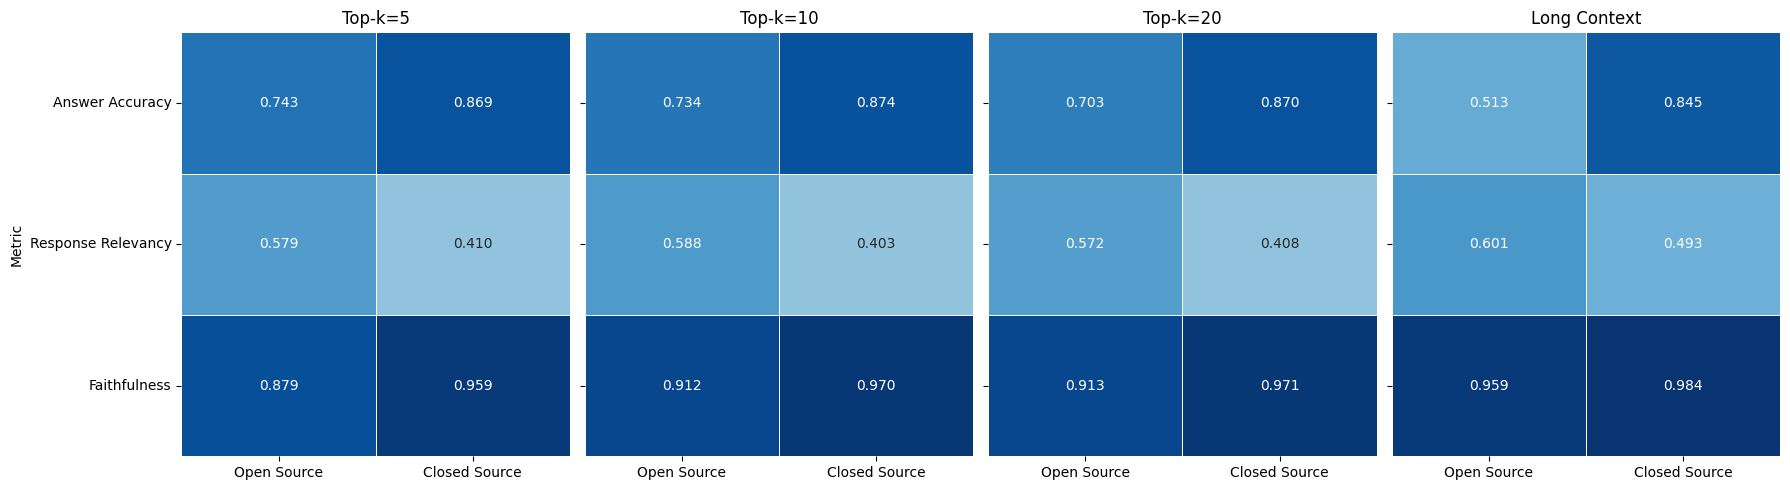

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_pickle("results/generation/2025-08-15_13-43-52.pkl")

# --- 1) Settings ---
METRICS = [
    "answer_accuracy",
    "response_relevancy",
    "faithfulness",
]
METRIC_LABELS = {
    "answer_accuracy": "Answer Accuracy",
    "response_relevancy": "Response Relevancy",
    "faithfulness": "Faithfulness",
}
CONFIGS = ["Top-k=5", "Top-k=10", "Top-k=20", "Long Context"]
SOURCES = ["Open Source", "Closed Source"]

# --- 2) Flexible regex ---
pat = re.compile(
    r"^(Open|Closed) Source (?:RAG \(Top-k=(\d+)\)|Long Context)_(answer_accuracy|response_relevancy|faithfulness)$",
    re.IGNORECASE
)

parsed = []
for col in df.columns:
    m = pat.match(col.strip())
    if not m:
        continue
    source = f"{m.group(1).title()} Source"
    k = m.group(2)
    config = f"Top-k={k}" if k is not None else "Long Context"
    metric = m.group(3).lower()
    if config in CONFIGS and metric in METRICS and source in SOURCES:
        parsed.append((col, source, config, metric))

parsed_df = pd.DataFrame(parsed, columns=["column", "source", "config", "metric"])

# --- 3) Prepare matrices for each config ---
heatmaps = {}
for config in CONFIGS:
    sub = parsed_df[parsed_df["config"] == config]
    mat = np.full((len(METRICS), len(SOURCES)), np.nan, dtype=float)
    def unwrap_single_element(val):
        """If val is a list/tuple with one element, return that element, else val."""
        if isinstance(val, (list, tuple)) and len(val) == 1:
            return val[0]
        return val

    # --- Inside the loop where we compute mean_val ---
    for _, row in sub.iterrows():
        # Unwrap list values first
        series = df[row["column"]].apply(unwrap_single_element)
        # Convert to numeric
        vals = pd.to_numeric(series, errors="coerce")
        mean_val = vals.mean(skipna=True)
        i = METRICS.index(row["metric"])
        j = SOURCES.index(row["source"])
        mat[i, j] = mean_val
    heatmaps[config] = pd.DataFrame(
        mat,
        index=[METRIC_LABELS[m] for m in METRICS],
        columns=SOURCES
    )

# --- 4) Plot horizontally with Seaborn style ---
fig, axes = plt.subplots(1, len(CONFIGS), figsize=(5*len(CONFIGS), 5), sharey=True)

if len(CONFIGS) == 1:
    axes = [axes]

for ax, config in zip(axes, CONFIGS):
    summary_df = heatmaps[config]
    sns.heatmap(
        summary_df,
        annot=True,
        cmap="Blues",
        fmt=".3f",
        cbar=False,
        linewidths=0.5,
        vmax=1.0,
        vmin=0,
        ax=ax
    )
    ax.set_title(config)
    if ax != axes[0]:
        ax.set_ylabel("")  # remove repeated ylabel
    else:
        ax.set_ylabel("Metric")

plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar
plt.show()
fig.savefig('figures/generation_eval_broad.pgf')

In [2]:
len(df[pd.notna(df["Open Source RAG (Top-k=5)_answer_accuracy"])])

600

In [7]:
df

,question,references,groundTruth,source_file,variations_pretty,documents,variant,prev_messages,Open Source RAG (Top-k=5)_answer_accuracy,Open Source RAG (Top-k=5)_response_relevancy,...,Closed Source Long Context_response_relevancy,Closed Source Long Context_faithfulness,Open Source RAG (Top-k=5)_answer,Open Source RAG (Top-k=10)_answer,Open Source RAG (Top-k=20)_answer,Open Source Long Context_answer,Closed Source RAG (Top-k=5)_answer,Closed Source RAG (Top-k=10)_answer,Closed Source RAG (Top-k=20)_answer,Closed Source Long Context_answer
0,Wie läuft eine äußere Wendung genau ab und was...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,default,[],0.50,0.940880,...,0.961130,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Und was passiert dann genau davor?,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,contextual,"[Ich habe von der äußeren Wendung gehört, könn...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wie genau läuft so ne äußere Wendung ab und wa...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,slang,[],0.75,0.935708,...,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,How is an external version performed exactly a...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,english,[],1.00,0.000000,...,0.000000,1.000000,"Okay, here's an explanation of how an external...",## What happens before and during an external ...,## External Version: What to Expect\n\nAn **ex...,## Performing an External Version: A Detailed ...,## What happens beforehand? 🩺🏥\n\nBefore an ex...,## Wie wird eine äußere Wendung genau durchgef...,## Kurzüberblick\nDie **äußere Wendung** ist e...,## Kurzüberblick – was ist eine äußere Wendung...
4,äußere Wendung Ablauf Vorbereitung,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=a3459c13c24fb9193e348f5e6777c69d7...,keyword,[],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,Risiken Ballonkatheter?,[Die Einlage und das Befüllen der Ballons könn...,Bei der Anwendung eines Ballonkatheters kann d...,Einleitung der Geburt.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=07f481a343764517c9c913312fb167532...,short,[],0.50,0.961809,...,0.000000,0.956522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,"Ich möchte wissen, welche möglichen Komplikati...",[Die Einlage und das Befüllen der Ballons könn...,Bei der Anwendung eines Ballonkatheters kann d...,Einleitung der Geburt.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=07f481a343764517c9c913312fb167532...,long,[],1.00,0.952841,...,0.921275,0.966667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,Welche potenziellen Komplikationen und Risiken...,[Die Einlage und das Befüllen der Ballons könn...,Bei der Anwendung eines Ballonkatheters kann d...,Einleitung der Geburt.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=07f481a343764517c9c913312fb167532...,technical,[],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,Welche Risiken gibt es bei der Anwendung eines...,[Die Einlage und das Befüllen der Ballons könn...,Bei der Anwendung eines Ballonkatheters kan

In [3]:
import pandas as pd

# 1. Select only columns ending with '_answer'
answer_cols = [col for col in df.columns if col.endswith("_answer")]

# 2. Define safe length function
def answer_length(text):
    if pd.isna(text):
        return 0
    return len(str(text).split())  # word count; use len(str(text)) for characters

# 3. Apply length function and compute averages
avg_lengths = df[answer_cols].applymap(answer_length).mean()

# 4. Format results as DataFrame
avg_lengths_df = avg_lengths.to_frame(name="Average Answer Length")
print(avg_lengths_df)

                                     Average Answer Length
Open Source RAG (Top-k=5)_answer                151.759016
Open Source RAG (Top-k=10)_answer               165.363934
Open Source RAG (Top-k=20)_answer               169.170492
Open Source Long Context_answer                 240.891803
Closed Source RAG (Top-k=5)_answer              176.993443
Closed Source RAG (Top-k=10)_answer             191.732787
Closed Source RAG (Top-k=20)_answer             200.145902
Closed Source Long Context_answer               217.885246


/tmp/ipykernel_2118206/3939133720.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  avg_lengths = df[answer_cols].applymap(answer_length).mean()


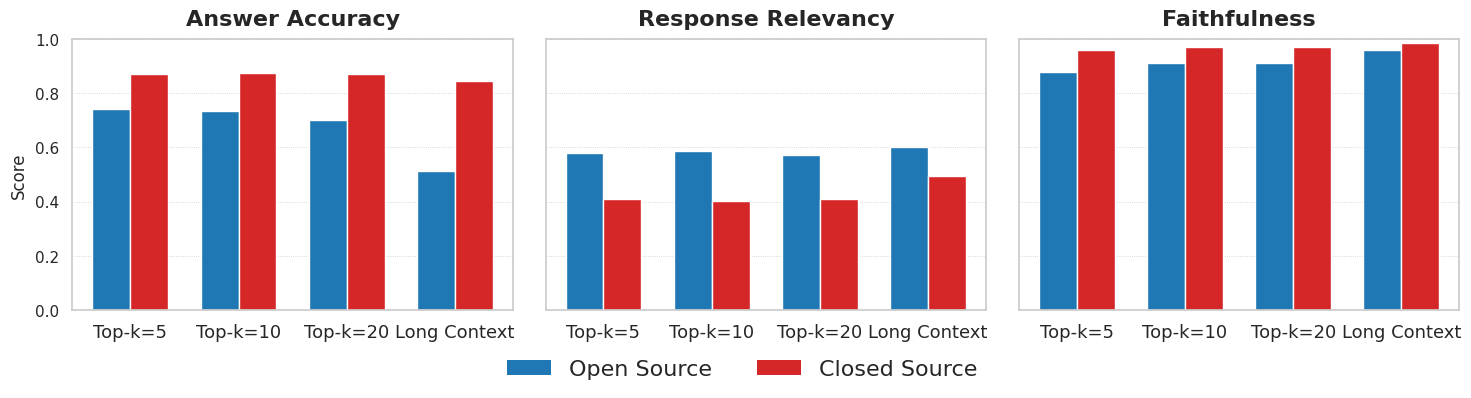

In [24]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# --- 1) Load ---
df = pd.read_pickle("results/generation/2025-08-15_13-43-52.pkl")

# --- 2) Settings ---
METRICS = ["answer_accuracy", "response_relevancy", "faithfulness"]
METRIC_LABELS = {
    "answer_accuracy": "Answer Accuracy",
    "response_relevancy": "Response Relevancy",
    "faithfulness": "Faithfulness",
}
CONFIGS = ["Top-k=5", "Top-k=10", "Top-k=20", "Long Context"]
SOURCES = ["Open Source", "Closed Source"]

# Colors by SOURCE (not by metric)
SOURCE_COLORS = {"Open Source": "#1f77b4",  # blue
                 "Closed Source": "#d62728"}  # red

# --- 3) Regex parse ---
pat = re.compile(
    r"^(Open|Closed) Source (?:RAG \(Top-k=(\d+)\)|Long Context)_(answer_accuracy|response_relevancy|faithfulness)$",
    re.IGNORECASE,
)

parsed = []
for col in df.columns:
    if not isinstance(col, str):
        continue
    m = pat.match(col.strip())
    if not m:
        continue
    source = f"{m.group(1).title()} Source"
    k = m.group(2)
    config = f"Top-k={k}" if k is not None else "Long Context"
    metric = m.group(3).lower()
    if config in CONFIGS and metric in METRICS and source in SOURCES:
        parsed.append((col, source, config, metric))

parsed_df = pd.DataFrame(parsed, columns=["column", "source", "config", "metric"])

# --- 4) Compute mean scores ---

def unwrap_single_element(val):
    if isinstance(val, (list, tuple)) and len(val) == 1:
        return val[0]
    return val

rows = []
for _, prow in parsed_df.iterrows():
    series = df[prow["column"]].apply(unwrap_single_element)
    vals = pd.to_numeric(series, errors="coerce")
    mean_val = vals.mean(skipna=True)
    rows.append({
        "metric": prow["metric"],
        "config": prow["config"],
        "source": prow["source"],
        "score": float(mean_val) if pd.notna(mean_val) else np.nan,
    })

tidy = pd.DataFrame(rows).dropna(subset=["score"])
# Ensure categorical ordering
for col, cats in [("metric", METRICS), ("config", CONFIGS), ("source", SOURCES)]:
    tidy[col] = pd.Categorical(tidy[col], categories=cats, ordered=True)

# --- 5) Plot: grouped bars per metric (configs on x-axis, grouped by source) ---
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, len(METRICS), figsize=(15, 4), sharey=True)
if len(METRICS) == 1:
    axes = [axes]

bar_width = 0.35  # width for each source group
x_positions = np.arange(len(CONFIGS))  # base positions for configs

for ax, metric in zip(axes, METRICS):
    sub = tidy[tidy["metric"] == metric]
    if sub.empty:
        ax.axis("off")
        continue

    # Map config to mean score per source
    for i, src in enumerate(SOURCES):
        sub_src = sub[sub["source"] == src].sort_values("config")
        if sub_src.empty:
            continue
        scores = sub_src["score"].values
        # Align scores with CONFIG ordering (in case some missing)
        score_map = {c: s for c, s in zip(sub_src["config"].astype(str), scores)}
        aligned_scores = [score_map.get(cfg, np.nan) for cfg in CONFIGS]
        offsets = x_positions + (i - (len(SOURCES) - 1) / 2) * bar_width
        ax.bar(offsets, aligned_scores, width=bar_width, color=SOURCE_COLORS[src], label=src)

    ax.set_xticks(x_positions)
    ax.set_xticklabels(CONFIGS, fontsize=13)
    ax.set_ylim(0.0, 1.0)
    ax.set_title(METRICS and METRIC_LABELS.get(metric, metric), fontsize=16, fontweight='bold', pad=10)
    if ax == axes[0]:
        ax.set_ylabel("Score", labelpad=5)
    else:
        ax.set_ylabel("")
    ax.yaxis.grid(True, linestyle=':', linewidth=0.6, alpha=1)

# Build legend (Source colors)
handles = [Patch(facecolor=SOURCE_COLORS[s], edgecolor="black", label=s) for s in SOURCES]
# Figure-level legend centered below subplots
for h in handles:
    h.set_edgecolor('none')
    h.set_linewidth(0)
    # Keep x-axis (bottom) spines visible (later code hides them)
    def _keep_bottom_spines_visible(event=None):
        for _ax in axes:
            _ax.spines['bottom'].set_visible(True)
    fig.canvas.mpl_connect('draw_event', _keep_bottom_spines_visible)

leg = fig.legend(handles=handles, loc='lower center', ncol=2, frameon=False,
                 fontsize=16, bbox_to_anchor=(0.5, -0.02))

# Remove x-axis grid lines and bottom axis line (spine)
for ax in axes:
    ax.xaxis.grid(False)
    ax.spines['bottom'].set_visible(False)
plt.tight_layout(rect=(0, 0.08, 1, 1))
plt.show()
fig.savefig("figures/generation_eval_metrics_horizontal.pgf")

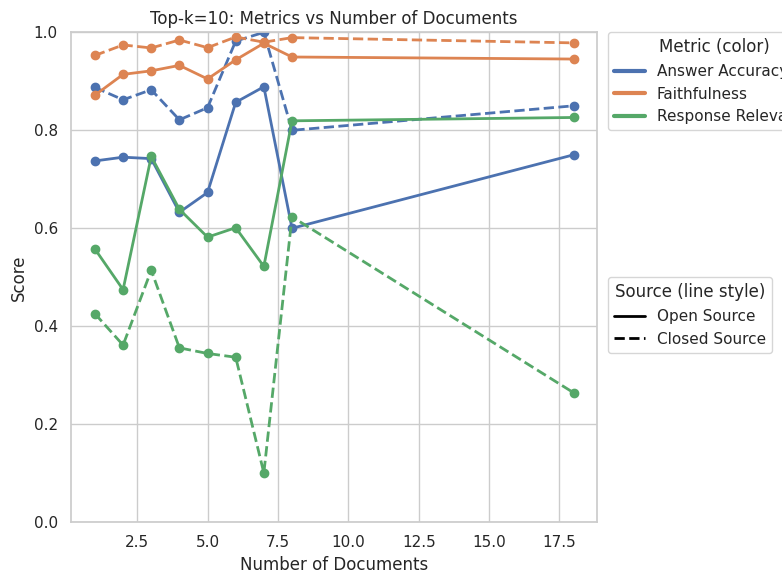

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# assumes `df` is already loaded (your big pickle with a "documents" column)

# --- unwrap helper ---
def unwrap_single_element(val):
    if isinstance(val, (list, tuple)) and len(val) == 1:
        return val[0]
    return val

# --- 1) Build tidy dataset again (like before) ---
rows = []
for col in df.columns:
    if not isinstance(col, str):
        continue
    if "_answer_accuracy" in col or "_response_relevancy" in col or "_faithfulness" in col:
        # detect meta info from col name
        if "Top-k=10" not in col:
            continue  # only keep top-k=10
        source = "Open Source" if col.lower().startswith("open") else "Closed Source"
        if "answer_accuracy" in col:
            metric = "answer_accuracy"
        elif "response_relevancy" in col:
            metric = "response_relevancy"
        elif "faithfulness" in col:
            metric = "faithfulness"
        else:
            continue

        # unwrap values
        series = df[col].apply(unwrap_single_element)
        vals = pd.to_numeric(series, errors="coerce")

        # get number of documents for each row (same index as df)
        num_docs = df["documents"].apply(lambda x: len(x) if isinstance(x, (list, tuple)) else np.nan)

        tmp = pd.DataFrame({
            "score": vals,
            "metric": metric,
            "source": source,
            "num_docs": num_docs
        })
        rows.append(tmp)

tidy_docs = pd.concat(rows, ignore_index=True).dropna(subset=["score", "num_docs"])

# --- 2) Aggregate: mean score per (metric, source, num_docs) ---
agg = (
    tidy_docs
    .groupby(["metric", "source", "num_docs"], as_index=False)["score"]
    .mean()
)

# --- 3) Plot ---
METRIC_LABELS = {
    "answer_accuracy": "Answer Accuracy",
    "response_relevancy": "Response Relevancy",
    "faithfulness": "Faithfulness",
}
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

palette = sns.color_palette(n_colors=agg["metric"].nunique())
metric_colors = {m: palette[i] for i, m in enumerate(agg["metric"].unique())}
source_styles = {"Open Source": "-", "Closed Source": "--"}

for metric in agg["metric"].unique():
    sub_m = agg[agg["metric"] == metric]
    for src in agg["source"].unique():
        sub_src = sub_m[sub_m["source"] == src].sort_values("num_docs")
        if sub_src.empty:
            continue
        plt.plot(
            sub_src["num_docs"],
            sub_src["score"],
            marker="o",
            linewidth=2,
            color=metric_colors[metric],
            linestyle=source_styles[src],
        )

plt.xlabel("Number of Documents")
plt.ylabel("Score")
plt.ylim(0.0, 1.0)
plt.title("Top-k=10: Metrics vs Number of Documents")

# legends
metric_handles = [
    Line2D([0], [0], color=metric_colors[m], lw=3, label=METRIC_LABELS.get(m, m))
    for m in agg["metric"].unique()
]
source_handles = [
    Line2D([0], [0], color="black", lw=2, linestyle=ls, label=src)
    for src, ls in source_styles.items()
]

leg1 = plt.legend(handles=metric_handles, title="Metric (color)",
                  bbox_to_anchor=(1.02, 1.0), loc="upper left", borderaxespad=0.)
plt.gca().add_artist(leg1)
plt.legend(handles=source_handles, title="Source (line style)",
           bbox_to_anchor=(1.02, 0.5), loc="upper left", borderaxespad=0.)

plt.tight_layout()
plt.show()

/tmp/ipykernel_2118206/23056627.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["metric", "source", "config", "num_docs"], as_index=False)


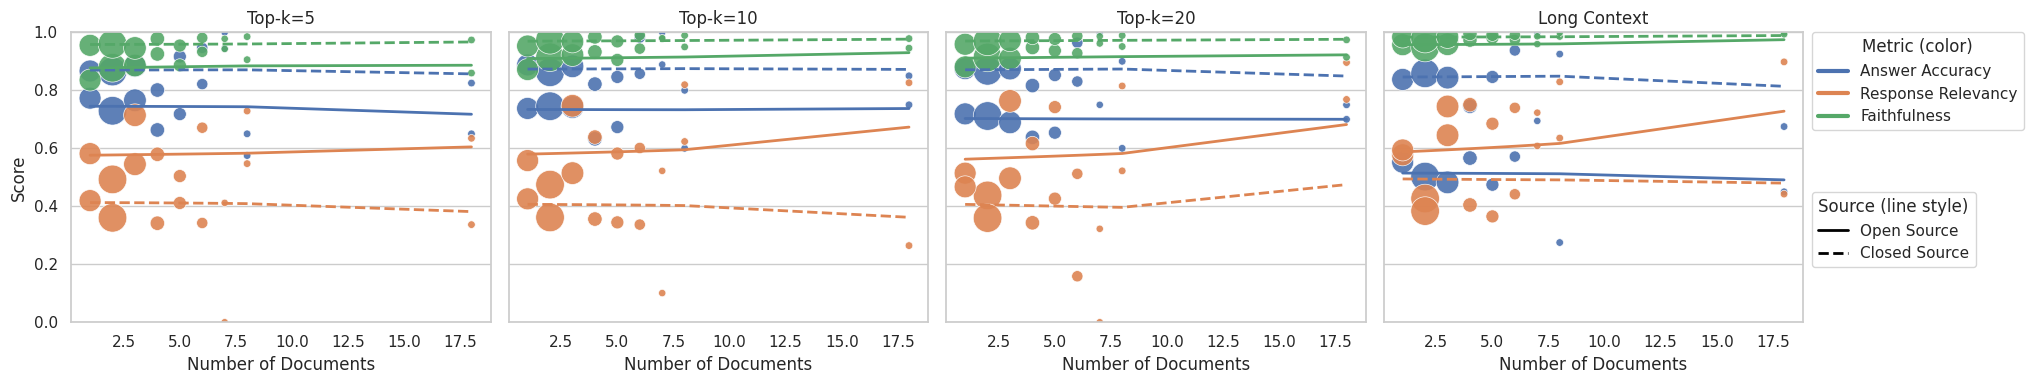

In [6]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Load ---
df = pd.read_pickle("results/generation/2025-08-15_13-43-52.pkl")

# --- Settings ---
METRICS = ["answer_accuracy", "response_relevancy", "faithfulness"]
METRIC_LABELS = {
    "answer_accuracy": "Answer Accuracy",
    "response_relevancy": "Response Relevancy",
    "faithfulness": "Faithfulness",
}
CONFIGS = ["Top-k=5", "Top-k=10", "Top-k=20", "Long Context"]
SOURCES = ["Open Source", "Closed Source"]

# How much to smooth (as a fraction of the x-range).
# Increase for smoother lines, decrease for more detail.
SMOOTH_SPAN_FRAC = 0.35

# --- Regex parse (same as before) ---
pat = re.compile(
    r"^(Open|Closed) Source (?:RAG \(Top-k=(\d+)\)|Long Context)_(answer_accuracy|response_relevancy|faithfulness)$",
    re.IGNORECASE,
)

parsed = []
for col in df.columns:
    if not isinstance(col, str):
        continue
    m = pat.match(col.strip())
    if not m:
        continue
    source = f"{m.group(1).title()} Source"
    k = m.group(2)
    config = f"Top-k={k}" if k is not None else "Long Context"
    metric = m.group(3).lower()
    if config in CONFIGS and metric in METRICS and source in SOURCES:
        parsed.append((col, source, config, metric))

parsed_df = pd.DataFrame(parsed, columns=["column", "source", "config", "metric"])

def unwrap_single_element(val):
    if isinstance(val, (list, tuple)) and len(val) == 1:
        return val[0]
    return val

# number of docs per row
num_docs_series = df["documents"].apply(
    lambda x: len(x) if isinstance(x, (list, tuple)) else (int(x) if pd.notna(x) and np.isscalar(x) else np.nan)
)

# Build tidy row-level data
rows = []
for _, r in parsed_df.iterrows():
    series = df[r["column"]].apply(unwrap_single_element)
    vals = pd.to_numeric(series, errors="coerce")
    rows.append(pd.DataFrame({
        "score": vals,
        "metric": r["metric"],
        "source": r["source"],
        "config": r["config"],
        "num_docs": num_docs_series,
    }))

tidy = pd.concat(rows, ignore_index=True).dropna(subset=["score", "num_docs"])
tidy["metric"] = pd.Categorical(tidy["metric"], categories=METRICS, ordered=True)
tidy["config"] = pd.Categorical(tidy["config"], categories=CONFIGS, ordered=True)
tidy["source"] = pd.Categorical(tidy["source"], categories=SOURCES, ordered=True)

# Aggregate to (metric, source, config, num_docs) with mean score and COUNT = weight
agg = (
    tidy
    .groupby(["metric", "source", "config", "num_docs"], as_index=False)
    .agg(score_mean=("score", "mean"), n=("score", "size"))
)

# --- Weighted kernel smoother (Gaussian) ---
def weighted_gaussian_smooth(x, y, w, x_grid=None, span_frac=0.35):
    """
    Returns (x_grid, y_smoothed) where y_smoothed[i] is a weighted average
    of y using Gaussian weights around x_grid[i]. Weights are multiplied by w.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    w = np.asarray(w, dtype=float)

    if x_grid is None:
        x_grid = np.unique(x)
    else:
        x_grid = np.asarray(x_grid, dtype=float)

    rng = x.max() - x.min() if len(x) > 1 else 1.0
    h = max(1.0, span_frac * rng)  # bandwidth in "num_docs" units

    y_hat = np.empty_like(x_grid, dtype=float)
    for i, x0 in enumerate(x_grid):
        # Gaussian kernel centered at x0
        kern = np.exp(-0.5 * ((x - x0) / h) ** 2)
        ww = w * kern
        denom = ww.sum()
        y_hat[i] = (ww @ y) / denom if denom > 0 else np.nan
    return x_grid, y_hat

# --- Plot: one subplot per config, horizontally; color=metric, linestyle=source ---
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, len(CONFIGS), figsize=(5 * len(CONFIGS), 4), sharey=True)

palette = sns.color_palette(n_colors=len(METRICS))
metric_colors = {m: palette[i] for i, m in enumerate(METRICS)}
source_styles = {"Open Source": "-", "Closed Source": "--"}

for ax, config in zip(axes, CONFIGS):
    sub_c = agg[agg["config"] == config]
    if sub_c.empty:
        ax.axis("off")
        ax.set_title(config)
        continue

    # grid of x values (sorted unique num_docs) for smooth curves
    x_grid = np.sort(sub_c["num_docs"].unique())

    for metric in METRICS:
        for src in SOURCES:
            sub = sub_c[(sub_c["metric"] == metric) & (sub_c["source"] == src)].sort_values("num_docs")
            if sub.empty:
                continue

            # smoothed, weighted by counts n
            x_s, y_s = weighted_gaussian_smooth(
                sub["num_docs"].values,
                sub["score_mean"].values,
                sub["n"].values,
                x_grid=x_grid,
                span_frac=SMOOTH_SPAN_FRAC
            )

            # plot smoothed line
            ax.plot(
                x_s, y_s,
                linewidth=2,
                color=metric_colors[metric],
                linestyle=source_styles[src],
            )

            # (optional) show original points, size ~ weight
            ax.scatter(
                sub["num_docs"], sub["score_mean"],
                s=10 + 2.0 * sub["n"],           # emphasize high-count points
                color=metric_colors[metric],
                edgecolor="white",
                linewidth=0.5,
                alpha=0.9,
            )

    ax.set_title(config)
    ax.set_xlabel("Number of Documents")
    ax.set_ylim(0.0, 1.0)
    ax.grid(axis="x", visible=False)  # remove vertical grid lines
    if ax is axes[0]:
        ax.set_ylabel("Score")
    else:
        ax.set_ylabel("")

# Shared legends
metric_handles = [Line2D([0],[0], color=metric_colors[m], lw=3, label=METRIC_LABELS[m]) for m in METRICS]
source_handles = [Line2D([0],[0], color="black", lw=2, linestyle=ls, label=src) for src, ls in source_styles.items()]

leg1 = axes[-1].legend(handles=metric_handles, title="Metric (color)",
                       bbox_to_anchor=(1.02, 1.0), loc="upper left", borderaxespad=0.)
axes[-1].add_artist(leg1)
axes[-1].legend(handles=source_handles, title="Source (line style)",
                bbox_to_anchor=(1.02, 0.45), loc="upper left", borderaxespad=0.)

plt.tight_layout()
plt.show()
# fig.savefig("figures/generation_docs_vs_score_weighted_smooth.pgf")